# Linear regression for polynomials

In this notebook, you will perform linear regression to predict the values of function for which you have the values at a certain number of points. The aim to familiarize yourself with the concepts of underfitting and overfitting, and also with the impact of penalization strategies such as ridge regression and LASSO regularization.

**There are 10 questions to answer.**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse

## Data creation

The data is created by perturbing the output of a given polynomial.

In [2]:
# spacing between test points
dx_test = 0.1

# noise level for perturbation
sigma2 = 20

# function to learn
w = np.array([-1.5, 1 / 9.0])
def fct_to_learn(x):
    return w[0] * x + w[1] * np.square(x)

# the parameter n is the number of train data points that will be considered
def make_1dregression_data(n=21):
    # reset the random seed when recreating data
    np.random.seed(0)
    # creation of x values for train and test; fixed design
    xtrain = np.linspace(0.0, 20, n)
    xtest = np.arange(0.0, 20, dx_test)
    # associated y values: function defined above, perturbed by noise
    ytrain = fct_to_learn(xtrain) + np.random.normal(0, 1, xtrain.shape) * np.sqrt(sigma2)
    ytest = fct_to_learn(xtest) + np.random.normal(0, 1, xtest.shape) * np.sqrt(sigma2)
    return xtrain, ytrain, xtest, ytest

In [3]:
n_data = 51
xtrain, ytrain, xtest, ytest = make_1dregression_data(n_data)

We plot the data to visualize the learning task.

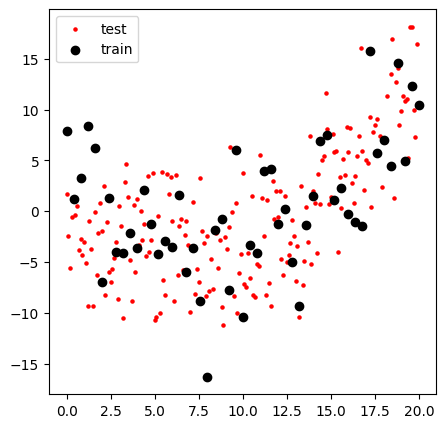

In [4]:
plt.figure(figsize=(5,5))
plt.scatter(xtest,ytest,color='red',s=5)
plt.scatter(xtrain,ytrain,color='black')
plt.legend(['test','train'])
plt.show()

**Question 1.** How would you change the code in order to do random design, *i.e.* consider training points sampled uniformly in the interval $[0,20]$?

In [6]:
# YOUR ANSWER HERE
xtrain = np.random.uniform(0.0,20,n_data)

We next rescale the data.

In [7]:
# Before rescaling
print('Before rescaling')
print('Train data: min =',np.min(xtrain),'max =',np.max(xtrain))
print('Test data:  min =',np.min(xtest), 'max =',np.max(xtest))

# Rescaling data, based on the train data + reshaping as column vector
scaler = MinMaxScaler(feature_range=(-1, 1))
Xtrain = scaler.fit_transform(xtrain.reshape(-1, 1))
Ytrain = ytrain.reshape(-1, 1)
Xtest = scaler.transform(xtest.reshape(-1, 1))
Ytest = ytest.reshape(-1, 1)

# After rescaling
print('\nAfter rescaling (based on train data)')
print('Train data: min =',np.min(Xtrain),'max =',np.max(Xtrain))
print('Test data:  min =',np.min(Xtest), 'max =',np.max(Xtest))

Before rescaling
Train data: min = 0.7072487151098183 max = 19.1886668166685
Test data:  min = 0.0 max = 19.900000000000002

After rescaling (based on train data)
Train data: min = -0.9999999999999999 max = 1.0000000000000002
Test data:  min = -1.07653619556934 max = 1.0769782036662556


## Fitting and predicting with polynomials of various degrees

We next consider fitting the model with polynomials of increasing degrees, and compute the accuracy on the test set.

In [8]:
max_deg = 10
degree = np.arange(0,max_deg+1,1)
features = Xtrain**degree
print("Shape of the feature vector:",features.shape)

Shape of the feature vector: (51, 11)


**Question 2.** Complete the code below to compute the weight obtained by ordinary least-squares.

In [9]:
coeff = []

for k in degree:
    # extract the first k+1 columns (i.e. 1, x, x**2, ..., x**k)
    feat = features[:,0:(k+1)]
    # compute the matrix (X^T X)^{-1} X^T
    # use @ for matrix multiplication [see https://peps.python.org/pep-0465/]
    # and .T for transpose [see https://numpy.org/doc/stable/reference/generated/numpy.ndarray.T.html]
    mat = np.linalg.inv( (feat.T)@feat )@(feat.T)
    # obtain the weights (denoted by theta in the lecture)
    weights = mat@Ytrain
    # append the weights for polynomials of degree k to the list of weights
    coeff.append(weights)

We can now the various polynomial predictions, as a function of the degree of the polynomial.

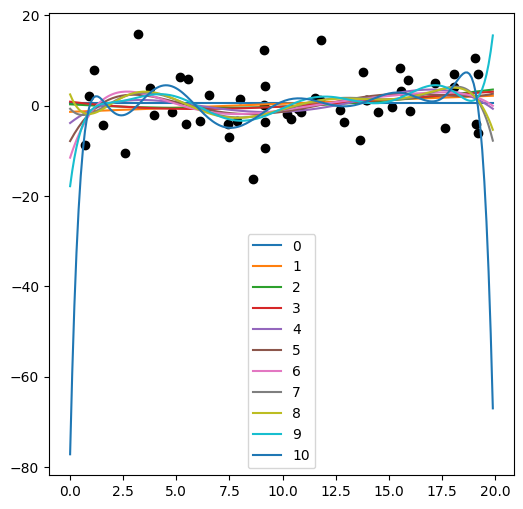

In [10]:
# we compute the design matrix for the test data
test_features = Xtest**degree

plt.figure(figsize=(6,6))
# looping over the polynomial degrees
for k in degree:
    # we compute the predictions for each test value x
    values = test_features[:,0:(k+1)]@coeff[k]
    # we plot these values as a function of the test values x
    plt.plot(xtest,values,label=k)
plt.legend()
plt.scatter(xtrain,ytrain,color='black')
plt.show()

**Question 3.** What happens in the absence of noise? Are the coefficients of the predicted polynomials close to the initial coefficients of the function *fct_to_learn*?

There is a perfect fit when there is no noise. Note that the coefficients are different from the original coefficients in the unknown function since the data has been rescaled on the $x$ axis. When noise is present, we can compare the performance of the fit on the train and test data.

We can next plot the train and test errors as a function of the complexity of the model (degree of the polynomial here).

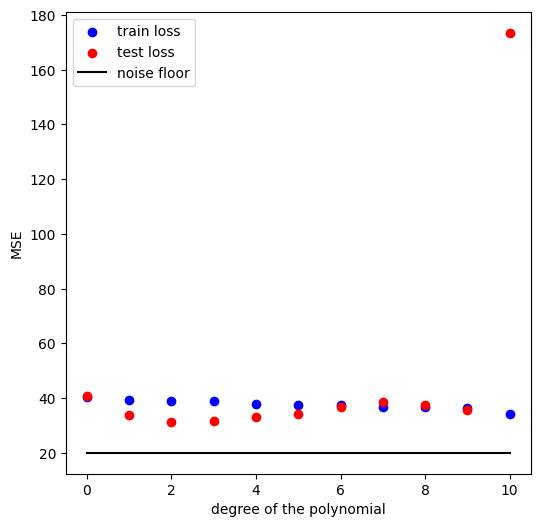

In [11]:
train_loss = np.zeros(degree.shape)
test_loss = np.zeros(degree.shape)

test_features = Xtest**degree
train_features = Xtrain**degree

n_train = Xtrain.shape[0]
n_test = Xtest.shape[0]

for k in degree:
    train_values = train_features[:,0:(k+1)]@coeff[k]
    train_loss[k] = np.sum((train_values-Ytrain)**2)/n_train
    test_values = test_features[:,0:(k+1)]@coeff[k]
    test_loss[k] = np.sum((test_values-Ytest)**2)/n_test

plt.figure(figsize=(6,6))
plt.scatter(degree,train_loss,color='blue',label='train loss')
plt.scatter(degree,test_loss,color='red',label='test loss')
plt.plot(degree,sigma2*np.ones(degree.shape),color='black',label='noise floor')
plt.xlabel('degree of the polynomial')
plt.ylabel('MSE')
plt.legend()
plt.show()

**Question 4.** In view of the results, which value of the degree of the polynomial should be chosen? How does the predictions behave when the number of training data is varied?

The behavior of the test error suggests that a polynomial of degree 2 should be used. Note also that there is a lower bound to the MSE, which depends on the level of noise (the so-called "noise floor" mentioned in Section 4.5.7 of [Murphy]).

When more data is added, the test error comes closer to the train error. Note that for large enough degrees and when there is sufficient data, the train error is typically below the noise floor, while the test error is above. Both converge the noise floor as the sample size is increased.

**Question 5.** Resume the study for randomly spaced input points $x_i$ ("random design" of Question 1). What do you observe?

The errors are larger with randomly spaced input points.

## Regularization with ridge regression from sratch

We now fix the degree of the polynomial to a large value, and add a regularization term to the loss function in order to prevent overfitting. The magnitude of the regularization is determined by cross validation.

In [12]:
deg = 15
degree = np.arange(0,deg+1,1)
train_features = Xtrain**degree
test_features = Xtest**degree
n_train = Xtrain.shape[0]
n_test = Xtest.shape[0]
print("Shape of the feature vector (train):",train_features.shape)

# we choose values of the regularization parameter logarithmically spaced
lambdas = np.logspace(-10, 2, 50)
n_lambdas = len(lambdas)
train_loss = np.empty(n_lambdas)
test_loss = np.empty(n_lambdas)

Shape of the feature vector (train): (51, 16)


**Question 6.** Implement the predictor.

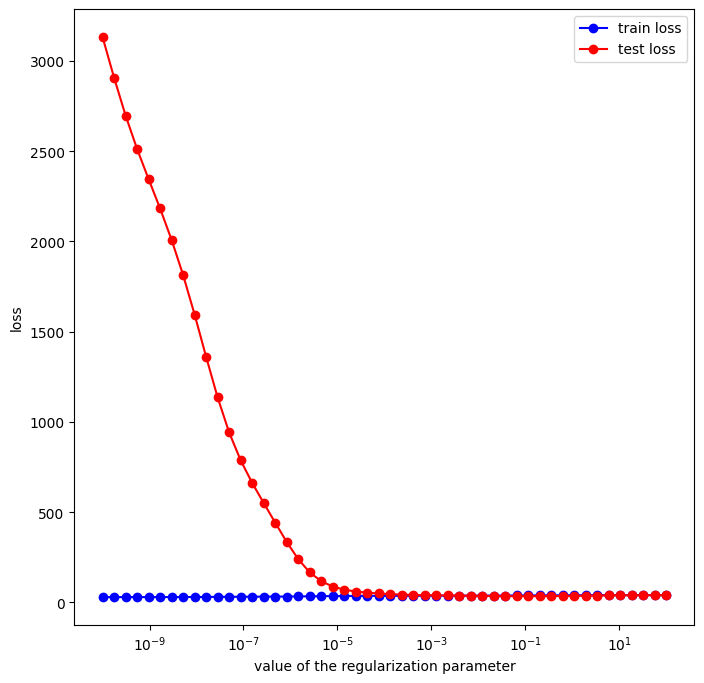

In [13]:
# we iterate over the values of alpha and compute the corresponding predictions
for k, alpha in enumerate(lambdas):
    # COMPUTE THE MATRIX FOR RIDGE REGRESSION; mind the n_train factor...
    mat = np.linalg.inv( (train_features.T)@train_features + n_train*alpha*np.identity(deg+1))@(train_features.T)
    weights = mat@Ytrain
    train_values = train_features@weights
    train_loss[k] = np.sum((train_values-Ytrain)**2)/n_train
    test_values = test_features@weights
    test_loss[k] = np.sum((test_values-Ytest)**2)/n_test

# we can finally plot the results
plt.figure(figsize=(8,8))
plt.semilogx(lambdas,train_loss,color='blue',label='train loss',marker='o')
plt.semilogx(lambdas,test_loss,color='red',label='test loss',marker='o')
plt.xlabel('value of the regularization parameter')
plt.ylabel('loss')
plt.legend()
plt.show()

**Question 7.** Determine the optimal regularization parameter $\lambda_n^*$.

In [14]:
index = np.argmin(test_loss)
alpha = lambdas[index]
print("Value of the optimal regularization parameter",alpha)

Value of the optimal regularization parameter 0.11513953993264481


We can finally plot the best prediction.

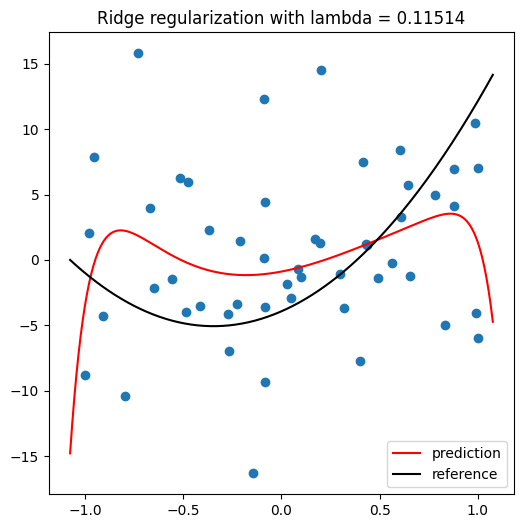

In [15]:
# ground truth corresponding to noiseless data
reference_values = fct_to_learn(xtest)

# best prediction with ridge regularization
mat = np.linalg.inv( (train_features.T)@train_features + alpha*np.identity(deg+1))@(train_features.T)
weights = mat@Ytrain
test_values = test_features@weights

# plotting the results
plt.figure(figsize=(6,6))
plt.scatter(Xtrain, Ytrain)
plt.plot(Xtest, test_values,color='red',label='prediction')
plt.plot(Xtest, reference_values,color='black',label='reference')
plt.title("Ridge regularization with lambda = {:0.5f}".format(alpha))
plt.legend()
plt.show()

We could also plot some learning curves, as done in Section 4.5.7 of [Murphy] for instance.

**Question 8.** How does the value of $\lambda^*$ depend on the number of data points $n$?

For $n=21$, one finds $\lambda^* = 0.021$. For $n=51$ and $101$, one finds $\lambda^* = 0.012$. The value does not have a clear decrease when the sample size increases.

## Regularization with ridge regression using scikit-learn

We finally use the built-in functions of scikit-learn to reproduce the above results.

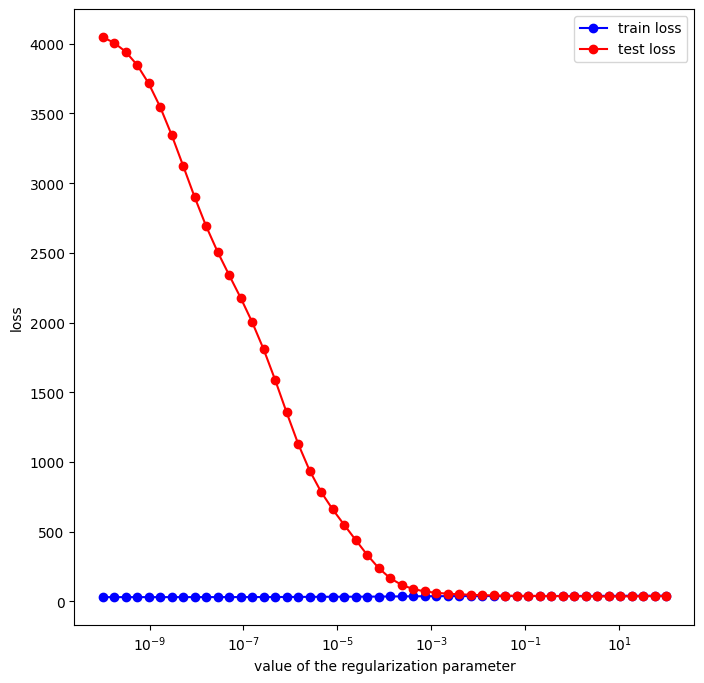

In [16]:
train_loss = np.empty(n_lambdas)
test_loss = np.empty(n_lambdas)
ytest_pred_stored = dict()

for i, alpha in enumerate(lambdas):
    # choose the model: ridge regression
    # see https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html
    model = Ridge(alpha=alpha, fit_intercept=True)
    # preprocessing: construct the feature vector, using functions specific for polynomial fitting
    # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html
    poly_features = PolynomialFeatures(degree=deg, include_bias=True)
    Xtrain_poly = poly_features.fit_transform(Xtrain)
    # fit the model
    model.fit(Xtrain_poly, ytrain)
    # predict the output for the train and test data
    ytrain_pred = model.predict(Xtrain_poly)
    train_loss[i] = mse(ytrain_pred, ytrain)
    Xtest_poly = poly_features.transform(Xtest)
    ytest_pred = model.predict(Xtest_poly)
    test_loss[i] = mse(ytest_pred, ytest)
    # store the prediction on the test data for further use
    ytest_pred_stored[alpha] = ytest_pred

plt.figure(figsize=(8,8))
plt.semilogx(lambdas,train_loss,color='blue',label='train loss',marker='o')
plt.semilogx(lambdas,test_loss,color='red',label='test loss',marker='o')
plt.xlabel('value of the regularization parameter')
plt.ylabel('loss')
plt.legend()
plt.show()

**Question 9.** Compare the optimal value with the one found above. How do they compare?

In [17]:
index = np.argmin(test_loss)
alpha = lambdas[index]
print("Value of the optimal regularization parameter",alpha)

Value of the optimal regularization parameter 3.39322177189533


The values are quite different since the normalizations in the functions which are optimized are different. Indeed, as mentioned in https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html, the function which is optimized is $\|Y-X\theta\|^2 + \lambda \|\theta\|^2$ and not $\frac1n \|Y-X\theta\|^2 + \lambda \|\theta\|^2$ as we considered. The value returned by sklearn is therefore the value we have computed multiplied by the sample size $n$ (see the code below).

In [18]:
alpha/n_train

0.06653376023324176

We can plot a few selected predictions.

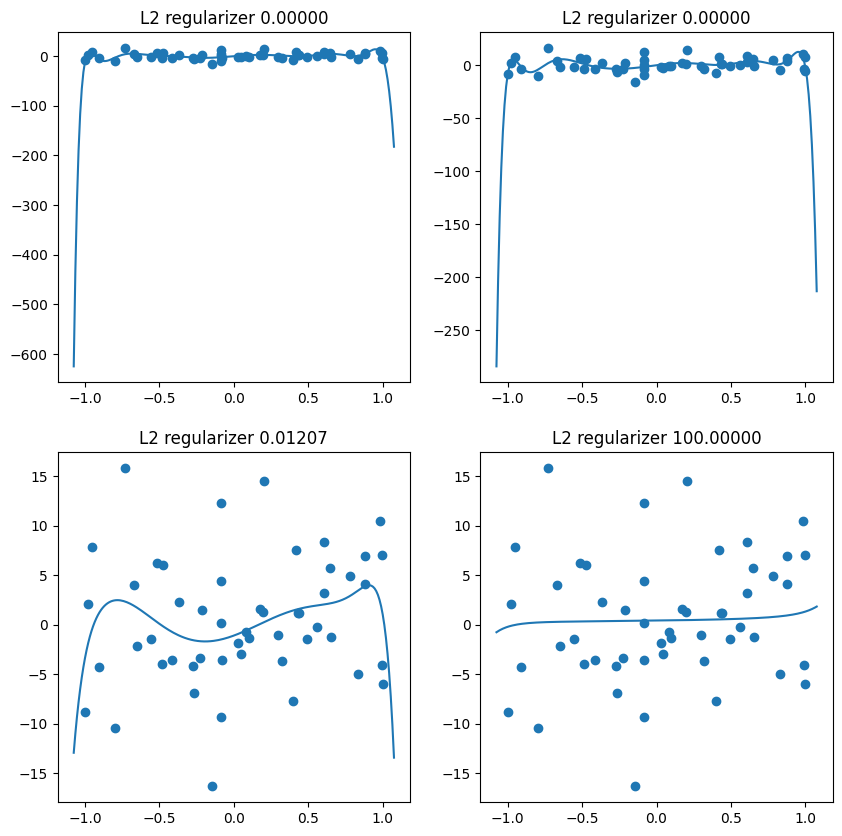

In [19]:
plt.figure(figsize=(10, 10))
max_index_lambda = len(lambdas)
chosen_lambdas = lambdas[[0, int(max_index_lambda/3), int(2*max_index_lambda/3), max_index_lambda-1]]
for i, alpha in enumerate(chosen_lambdas):
    plt.subplot(2,2,i+1)
    plt.scatter(Xtrain, ytrain)
    plt.plot(Xtest, ytest_pred_stored[alpha])
    plt.title("L2 regularizer {:0.5f}".format(alpha))
plt.show()

## Regularization with LASSO

We finally consider LASSO instead of ridge regression. When the design matrix $X$ is such that $X^\top X = n \mathrm{Id}$, the solution to Lasso can be computed explicitly, see for instance pages 19 and 24 of http://weixingsong.weebly.com/uploads/7/4/3/5/7435707/stat905_lecture5.pdf
In the general case, finding the weights should be seen as a convex programming problem, solved here using built-in scikit-learn functions, which perform coordinate descent (as solving one dimensional problems in Lasso is simple).

In [20]:
# we choose values of the regularization parameter logarithmically spaced
lambdas = np.logspace(-5, 1, 250)
n_lambdas = len(lambdas)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.254e+02, tolerance: 2.059e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.250e+02, tolerance: 2.059e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.246e+02, tolerance: 2.059e

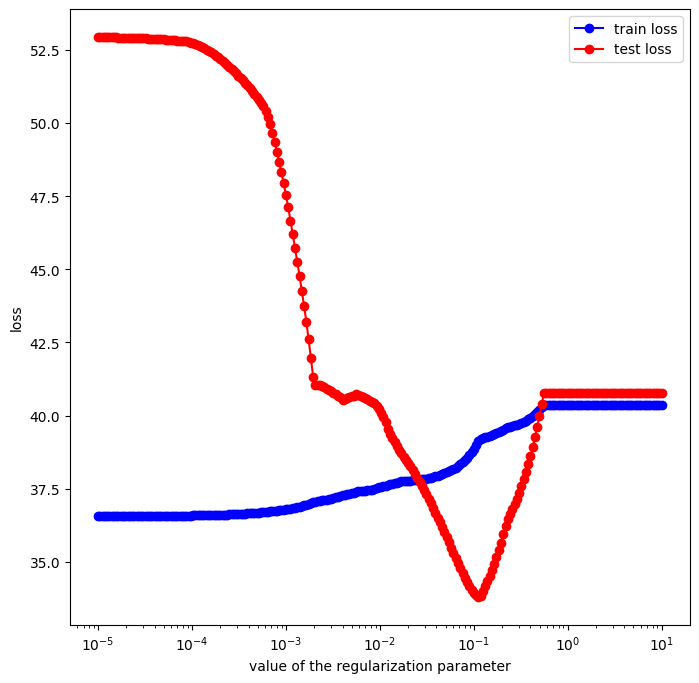

In [21]:
train_loss = np.empty(n_lambdas)
test_loss = np.empty(n_lambdas)
ytest_pred_stored = dict()

for i, alpha in enumerate(lambdas):
    # choose the model: LASSO regression
    # see https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html
    model = Lasso(alpha=alpha, fit_intercept=True)
    # preprocessing (as for ridge regression)
    poly_features = PolynomialFeatures(degree=deg, include_bias=True)
    Xtrain_poly = poly_features.fit_transform(Xtrain)
    # fit the model
    model.fit(Xtrain_poly, ytrain)
    # predict the output for the train and test data
    ytrain_pred = model.predict(Xtrain_poly)
    train_loss[i] = mse(ytrain_pred, ytrain)
    Xtest_poly = poly_features.transform(Xtest)
    ytest_pred = model.predict(Xtest_poly)
    test_loss[i] = mse(ytest_pred, ytest)
    # store the prediction on the test data for further use
    ytest_pred_stored[alpha] = ytest_pred

plt.figure(figsize=(8,8))
plt.semilogx(lambdas,train_loss,color='blue',label='train loss',marker='o')
plt.semilogx(lambdas,test_loss,color='red',label='test loss',marker='o')
plt.xlabel('value of the regularization parameter')
plt.ylabel('loss')
plt.legend()
plt.show()

It seems that the numerical method to perform optimization has troubles converging for small values of $\lambda$... Let's investigate this more precisely.

In [22]:
alpha_value = 0.001
model = Lasso(alpha=alpha_value, fit_intercept=True)
poly_features = PolynomialFeatures(degree=deg, include_bias=True)
Xtrain_poly = poly_features.fit_transform(Xtrain)
model.fit(Xtrain_poly, ytrain)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.249e+02, tolerance: 2.059e-01
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0.001)

Since we want to fix the value of $\lambda$ and already have rescaled features, the only remaining option is to increase the number of iterations (set by default to 1000).

In [23]:
alpha_value = 0.001
# increase progressively from 1000, as 2000, 3000, ... to see the better convergence
# (measured in terms of duality gap/tolerance)
maximal_nb_iterations = 10000
model = Lasso(alpha=alpha_value, fit_intercept=True, max_iter=maximal_nb_iterations)
poly_features = PolynomialFeatures(degree=deg, include_bias=True)
Xtrain_poly = poly_features.fit_transform(Xtrain)
model.fit(Xtrain_poly, ytrain)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.150e+01, tolerance: 2.059e-01
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0.001, max_iter=10000)

We come back to finding the best value of the regularization parameter for LASSO, and looking at the associated predictions.

In [24]:
index = np.argmin(test_loss)
alpha_opt = lambdas[index]
print("Value of the optimal regularization parameter:",alpha_opt)

Value of the optimal regularization parameter: 0.11173591019485102


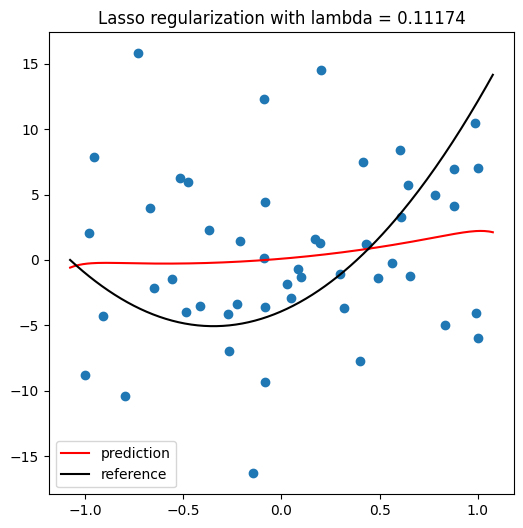

In [25]:
plt.figure(figsize=(6,6))
plt.scatter(Xtrain, Ytrain)
plt.plot(Xtest,ytest_pred_stored[alpha_opt],color='red',label='prediction')
plt.plot(Xtest,reference_values,color='black',label='reference')
plt.title("Lasso regularization with lambda = {:0.5f}".format(alpha_opt))
plt.legend()
plt.show()

**Question 10.** Determine the coefficients obtained with LASSO for the optimal value of the regularization parameter.

In [26]:
model = Lasso(alpha_opt, fit_intercept=True)
model.fit(Xtrain_poly, ytrain)
model.coef_

array([ 0.        ,  1.25637077,  1.06526446,  0.        ,  0.        ,
        0.        , -0.        ,  0.        , -0.        ,  0.        ,
       -0.        ,  0.        , -0.        ,  0.        , -0.19963515,
        0.        ])

Many coefficients are set to 0! One sees very well the sparsity inducing effect of the regularization.